# Model Time Series for COVID : Training

This notebook explore from official "Sante Publique France" data about COVID-19 in France


These data have 4-days time delay.

The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input).


**Input Features are daily data of:**

- Min/Max Temperatures
- Min/Max Humidities
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Tested cases
- Mean Age of Confirmed cases

**DATA sources:**

Tested / Confirmed cases: https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19

Météo France : https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm

**GitHub:** https://github.com/jeugregg/coronavirusModel

## import

In [7]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# projects libs
from my_helpers.data_plots import get_data_pos
from my_helpers.data_plots import load_data_pos
from my_helpers.data_plots import get_old_data_pos
from my_helpers.data_plots import load_old_data_pos
from my_helpers.data_plots import PATH_DF_GOUV_FR_OLD
from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda
from my_helpers.model import retrieve_from_lambda
from my_helpers.model import create_list_past_hist
from my_helpers.model import predict_list

## Definitions

In [2]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_SINGLE_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_single_step_pos_fr"
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr"
PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
    'serverless/tensorflow_lite_on_aws_lambda'
PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
    "converted_model.tflite"
PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
PAST_HISTORY = 14 # days used to predict next values in future
FUTURE_TARGET = 7 # nb predict days later
STEP = 1

# plot
NB_DAY_PLOT = FUTURE_TARGET*9

##  Helper functions

In [3]:
# FOR MODEL
"""def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    '''
    Create dataset for training : create each samples (timeseries data)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)"""

# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, step=1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1, step)]
    else:
        return None


# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [4]:
get_data_pos()
df_feat_fr = load_data_pos()

Must load more last days, 5 days missing
2334 records downloaded


In [5]:
df_feat_fr

T_min        date       T_max      H_min      H_max    pos  \
date                                                                          
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593    882   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458    981   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102   1031   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483    291   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000    139   
...                ...         ...         ...        ...        ...    ...   
2020-10-20  286.455000  2020-10-20  292.686667  65.169492  87.322034  42752   
2020-10-21  287.806897  2020-10-21  294.398276  59.245614  86.561404  44953   
2020-10-22  288.068333  2020-10-22  293.946667  66.254237  90.338983  48369   
2020-10-23  287.036441  2020-10-23  292.078814  70.017241  92.896552  49650   
2020-10-24  286.104237  2020-10-24  292.195763  66.327586  91.137931  20791   

              age_pos    test   age_test  day_num  nb_cases  
date                                                         
2020-05-13  60.987528   38635  55.467659        3    141109  
2020-05-14  60.434251   41431  54.807270        4    142090  
2020-05-15  59.838991   46862  54.316546        5    143121  
2020-05-16  60.158076   16102  54.352938        6    143412  
2020-05-17  61.568345    6249  58.058569        0    143551  
...               ...     ...        ...      ...       ...  
2020-10-20  47.891724  232637  46.025035        2   1004074  
2020-10-21  47.892221  236866  45.671688        3   1049027  
2020-10-22  47.876367  251342  46.241547        4   1097396  
2020-10-23  48.012145  266751  46.673043        5   1147046  
2020-10-24  47.526766  108847  46.477496        6   1167837  

[165 rows x 11 columns]

## Retrieve old data

In [9]:
if not os.path.isfile(PATH_DF_GOUV_FR_OLD):
    get_old_data_pos()
    
df_feat_fr_old = load_old_data_pos()

df_feat_fr_old

date       T_min       T_max      H_min      H_max  pos  \
date                                                                        
2020-03-10  2020-03-10  283.708333  289.736667  70.666667  90.416667    8   
2020-03-11  2020-03-11  285.335000  291.913333  66.183333  91.383333   16   
2020-03-12  2020-03-12  284.048333  290.268333  63.866667  89.883333   33   
2020-03-13  2020-03-13  282.503333  289.148333  56.150000  88.500000   61   
2020-03-14  2020-03-14  282.253333  289.338333  62.116667  88.683333   54   
...                ...         ...         ...        ...        ...  ...   
2020-05-08  2020-05-08  287.051695  296.029661  53.568966  86.327586   15   
2020-05-09  2020-05-09  288.019492  295.305932  60.448276  87.448276   29   
2020-05-10  2020-05-10  288.058621  293.532759  68.228070  92.649123   17   
2020-05-11  2020-05-11  284.517797  290.512712  67.310345  90.396552  210   
2020-05-12  2020-05-12  283.870000  289.811667  61.932203  86.322034  168   

              age_pos   test   age_test  day_num  nb_cases  
date                                                        
2020-03-10  66.625000     79  50.696203        2    101343  
2020-03-11  44.875000    108  45.587963        3    101359  
2020-03-12  58.681818    156  49.362179        4    101392  
2020-03-13  49.073770    350  44.335714        5    101453  
2020-03-14  51.222222    167  48.664671        6    101507  
...               ...    ...        ...      ...       ...  
2020-05-08  65.366667    448  59.638393        5    139803  
2020-05-09  45.431034   1513  52.868804        6    139832  
2020-05-10  61.676471    293  60.738908        0    139849  
2020-05-11  63.357143  10339  53.020892        1    140059  
2020-05-12  63.345238  10567  51.926706        2    140227  

[64 rows x 11 columns]

## Train/Test split

In [12]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

T_min        date       T_max      H_min      H_max    pos  \
date                                                                          
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593    882   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458    981   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102   1031   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483    291   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000    139   
...                ...         ...         ...        ...        ...    ...   
2020-10-22  288.068333  2020-10-22  293.946667  66.254237  90.338983  48940   
2020-10-23  287.036441  2020-10-23  292.078814  70.017241  92.896552  52533   
2020-10-24  286.104237  2020-10-24  292.195763  66.327586  91.137931  23577   
2020-10-25  284.972034  2020-10-25  291.231356  65.655172  90.327586   6774   
2020-10-26  284.690000  2020-10-26  289.685000  67.067797  90.491525  57160   

              age_pos    test   age_test  day_num  nb_cases  
date                                                         
2020-05-13  60.987528   38613  55.469013        3    141109  
2020-05-14  60.434251   41396  54.810127        4    142090  
2020-05-15  59.838991   46836  54.322679        5    143121  
2020-05-16  60.158076   16094  54.354356        6    143412  
2020-05-17  61.568345    6245  58.054604        0    143551  
...               ...     ...        ...      ...       ...  
2020-10-22  47.908214  253252  46.256278        4   1099014  
2020-10-23  48.007462  277455  46.673734        5   1151547  
2020-10-24  47.540993  120734  46.430161        6   1175124  
2020-10-25  49.660614   32030  47.858914        0   1181898  
2020-10-26  48.415308  272383  47.673434        1   1239058  

[167 rows x 11 columns]

In [5]:
# keep 25 Validation samples:
TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
#TRAIN_SPLIT = 45
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 151


In [6]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

T_min        date       T_max      H_min      H_max    pos  \
date                                                                          
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593    882   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458    981   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102   1031   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483    291   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000    139   
...                ...         ...         ...        ...        ...    ...   
2020-10-20  286.455000  2020-10-20  292.686667  65.169492  87.322034  42752   
2020-10-21  287.806897  2020-10-21  294.398276  59.245614  86.561404  44953   
2020-10-22  288.068333  2020-10-22  293.946667  66.254237  90.338983  48369   
2020-10-23  287.036441  2020-10-23  292.078814  70.017241  92.896552  49650   
2020-10-24  286.104237  2020-10-24  292.195763  66.327586  91.137931  20791   

              age_pos    test   age_test  day_num  nb_cases  train  
date                                                                
2020-05-13  60.987528   38635  55.467659        3    141109   True  
2020-05-14  60.434251   41431  54.807270        4    142090   True  
2020-05-15  59.838991   46862  54.316546        5    143121   True  
2020-05-16  60.158076   16102  54.352938        6    143412   True  
2020-05-17  61.568345    6249  58.058569        0    143551   True  
...               ...     ...        ...      ...       ...    ...  
2020-10-20  47.891724  232637  46.025035        2   1004074  False  
2020-10-21  47.892221  236866  45.671688        3   1049027  False  
2020-10-22  47.876367  251342  46.241547        4   1097396  False  
2020-10-23  48.012145  266751  46.673043        5   1147046  False  
2020-10-24  47.526766  108847  46.477496        6   1167837  False  

[165 rows x 12 columns]

## Exploration

Distribution of TRAIN / VALIDATION dataset :

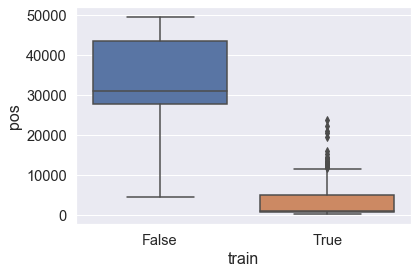

In [9]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### age

#### First wave

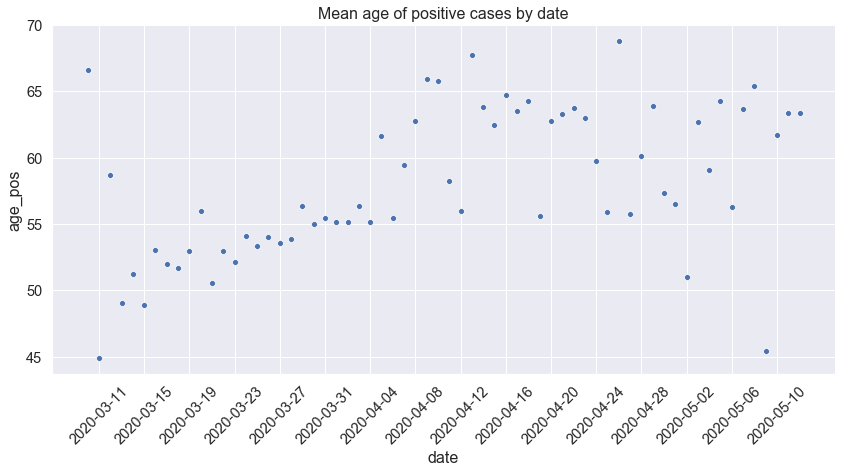

In [10]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr_old, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr_old["date"].min(), 
                    df_feat_fr_old["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

#### Second wave

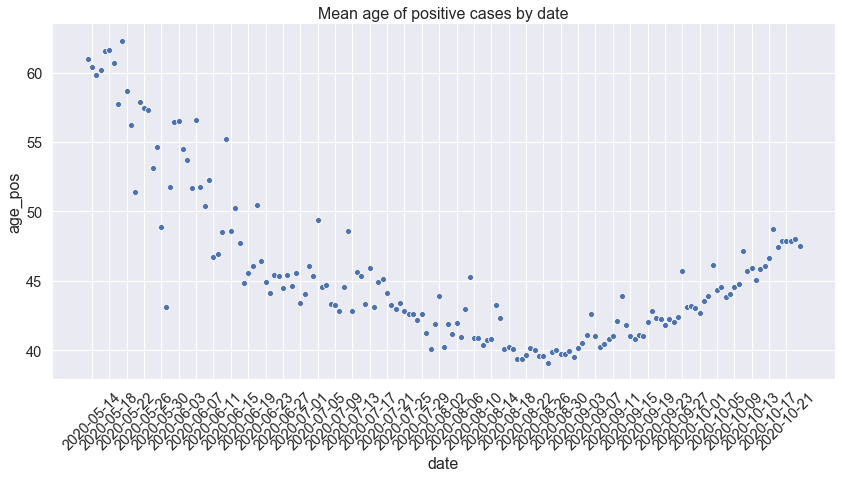

In [10]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr["date"].min(), 
                    df_feat_fr["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

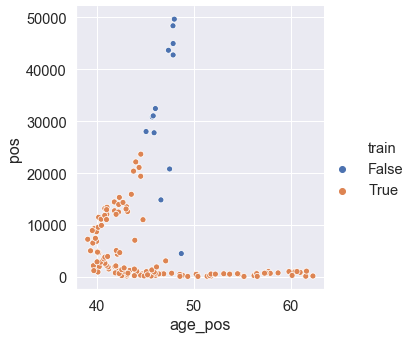

In [11]:
sns.relplot(x="age_pos", y="pos", hue="train", data=df_feat_fr);

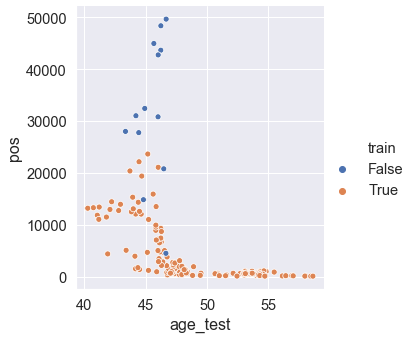

In [12]:
sns.relplot(x="age_test", y="pos", hue="train", data=df_feat_fr);

### Impact of day 

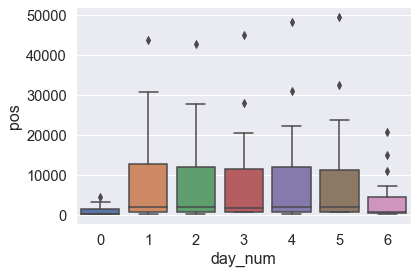

In [13]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [14]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

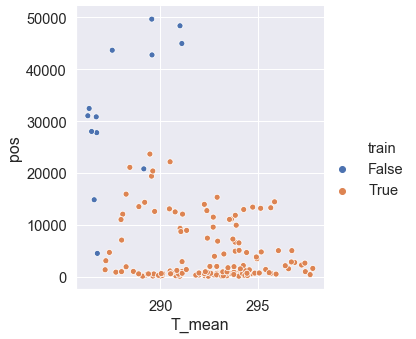

In [15]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

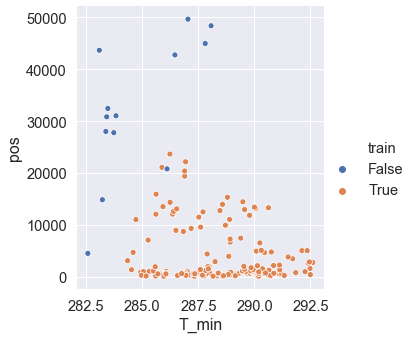

In [16]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

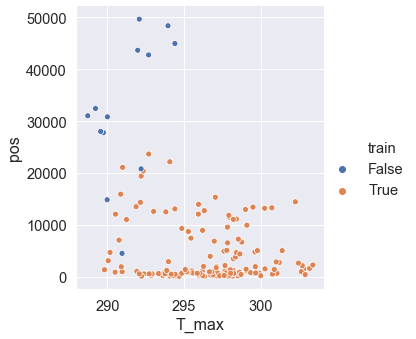

In [17]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

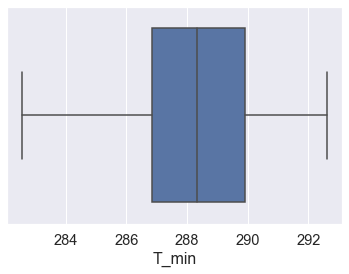

In [18]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [19]:
df_feat_fr["T_min"].mean()

288.2091677667505

In [20]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

False    84
True     81
Name: T_min, dtype: int64

In [21]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

False    83
True     82
Name: T_min, dtype: int64

In [22]:
df_feat_fr["T_min"].median()

288.3254385964912

In [23]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

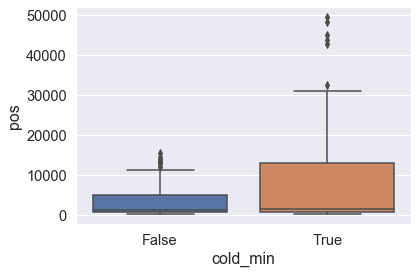

In [24]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then less positive cases! but trend is not clear (more deviation with cold temperature)

Impact of T mean : 

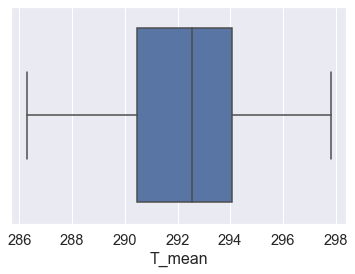

In [46]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [47]:
df_feat_fr["T_mean"].median()

292.54237288135596

In [48]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

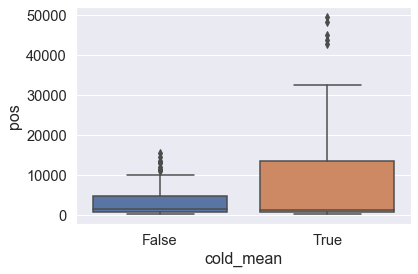

In [49]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

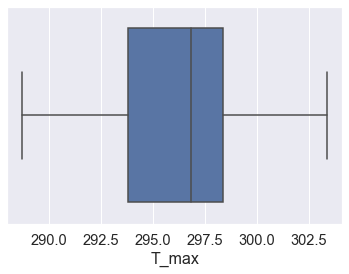

In [50]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [51]:
df_feat_fr["T_max"].median()

296.82627118644064

In [52]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

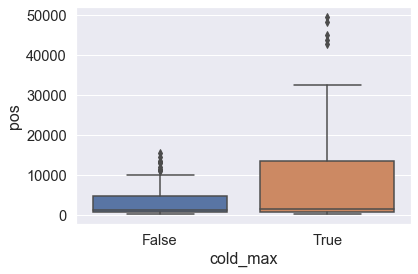

In [53]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> like T min

### Impact of Humidity

In [54]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

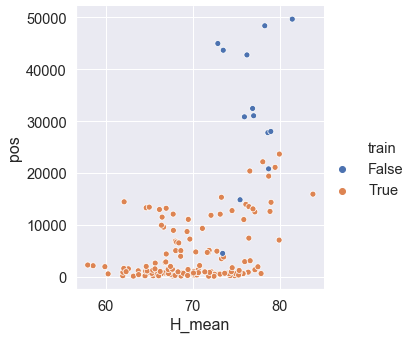

In [55]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

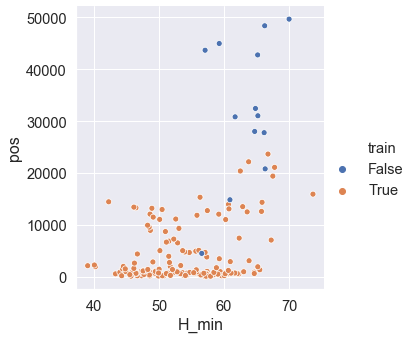

In [56]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

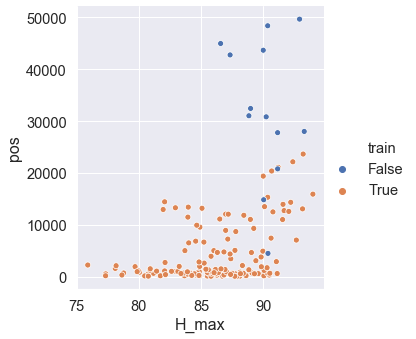

In [57]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

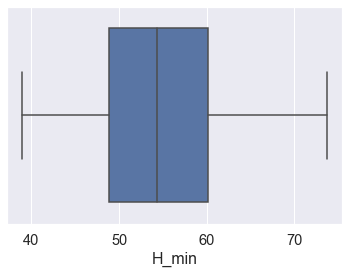

In [58]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [59]:
df_feat_fr["H_min"].median()

54.35593220338986

In [60]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

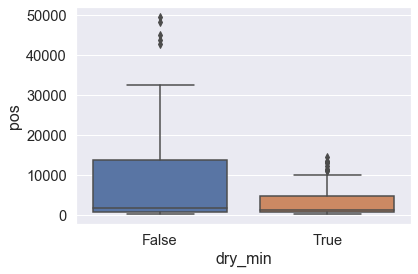

In [61]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)

=> no difference?

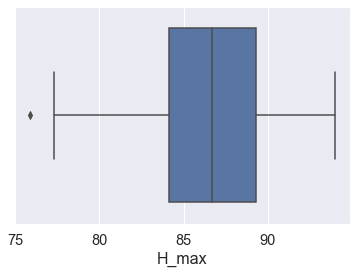

In [62]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [63]:
df_feat_fr["H_max"].median()

86.67857142857143

In [64]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

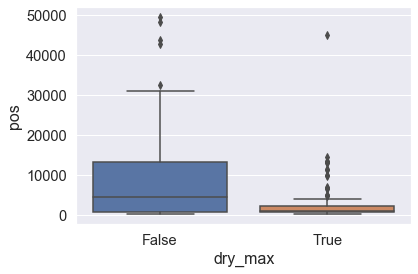

In [65]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)

=> real impact of Hmax?

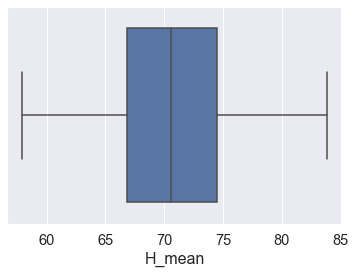

In [66]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [67]:
df_feat_fr["H_mean"].median()

70.55172413793103

In [68]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

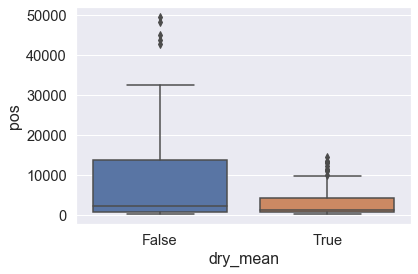

In [69]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)

=> Impact very difficult to find

### Seasonality impact

In [70]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

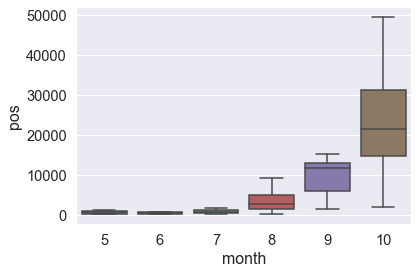

In [71]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

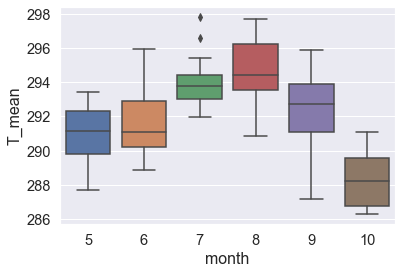

In [72]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

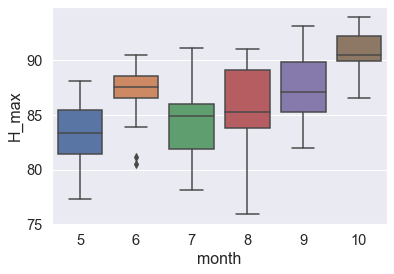

In [73]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [74]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

pos
month        
5       11749
6       14453
7       24558
8      105370
9      291899
10     579581

### Nb Tested

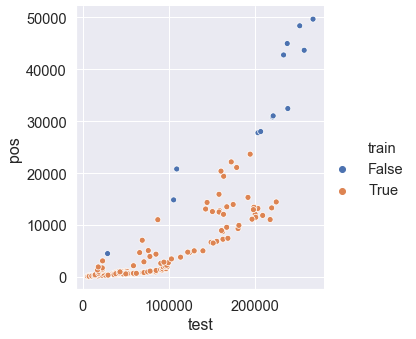

In [7]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [13]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [16]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=100*df_feat_fr_old["pos"] / df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

## Prepare features

In [78]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [79]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
features

T_min       T_max      H_min      H_max    pos    test  \
date                                                                      
2020-05-13  284.926667  290.505000  64.661017  88.135593    882   38635   
2020-05-14  285.050000  290.963333  59.406780  84.847458    981   41431   
2020-05-15  285.308333  291.920000  57.372881  82.966102   1031   46862   
2020-05-16  284.956667  293.500000  53.741379  86.534483    291   16102   
2020-05-17  285.598333  294.446667  49.879310  85.500000    139    6249   
...                ...         ...        ...        ...    ...     ...   
2020-10-20  286.455000  292.686667  65.169492  87.322034  42752  232637   
2020-10-21  287.806897  294.398276  59.245614  86.561404  44953  236866   
2020-10-22  288.068333  293.946667  66.254237  90.338983  48369  251342   
2020-10-23  287.036441  292.078814  70.017241  92.896552  49650  266751   
2020-10-24  286.104237  292.195763  66.327586  91.137931  20791  108847   

            day_num    age_pos   age_test  
date                                       
2020-05-13        3  60.987528  55.467659  
2020-05-14        4  60.434251  54.807270  
2020-05-15        5  59.838991  54.316546  
2020-05-16        6  60.158076  54.352938  
2020-05-17        0  61.568345  58.058569  
...             ...        ...        ...  
2020-10-20        2  47.891724  46.025035  
2020-10-21        3  47.892221  45.671688  
2020-10-22        4  47.876367  46.241547  
2020-10-23        5  48.012145  46.673043  
2020-10-24        6  47.526766  46.477496  

[165 rows x 9 columns]

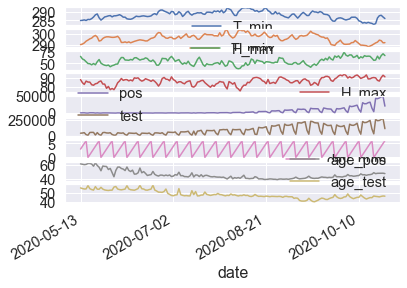

In [80]:
features.plot(subplots=True);

In [81]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

## Multi-step model

### Helper functions

In [82]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

### data 14D_to_7D

In [83]:
TRAIN_SPLIT

151

In [84]:
dataset.shape

(165, 9)

In [85]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [86]:
y_train_multi.shape

(137, 7)

In [87]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target temperature to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

137 Single window of past history : (14, 9)

 137 Target temperature to predict : (7,)


In [88]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 137
BUFFER_SIZE : 151

For validation : 
BATCH_SIZE_VAL : 7


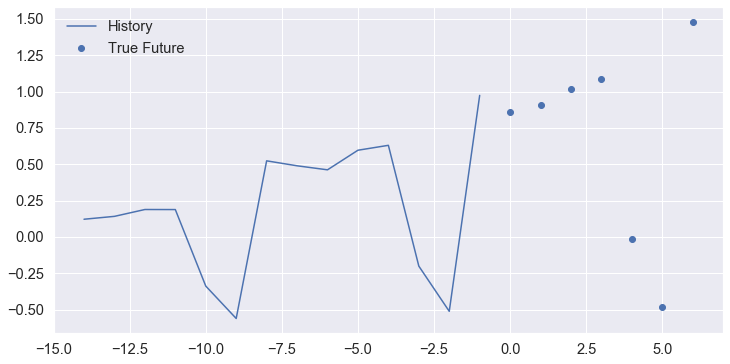

In [89]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [90]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 137
nb samples for validation : 7



 Run #0
Restoring model weights from the end of the best epoch.
Epoch 02824: early stopping
Run #0 : val_loss = 1.8875389099121094


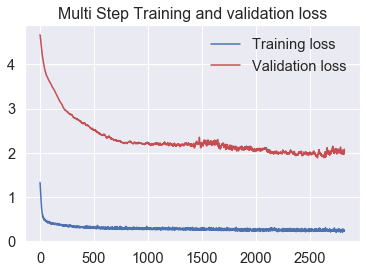

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 02068: early stopping
Run #1 : val_loss = 1.7765586376190186


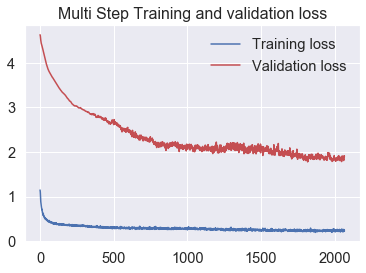

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 01911: early stopping
Run #2 : val_loss = 1.8094205856323242

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 03798: early stopping
Run #3 : val_loss = 1.3930875062942505


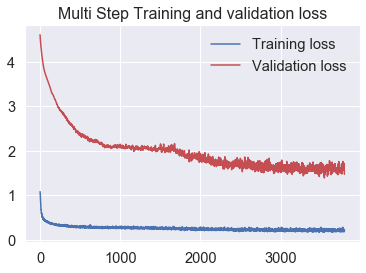

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 01987: early stopping
Run #4 : val_loss = 1.7688292264938354

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 01429: early stopping
Run #5 : val_loss = 2.1869049072265625

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 02027: early stopping
Run #6 : val_loss = 1.5854402780532837

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 01244: early stopping
Run #7 : val_loss = 1.9545319080352783

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 01418: early stopping
Run #8 : val_loss = 1.9375019073486328

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 01144: early stopping
Run #9 : val_loss = 2.1307318210601807

 Run #10
Restoring model weights from the end of the best epoch.
Epoch 01240: early stopping
Run #10 : val_loss = 2.1022486686706543

 Run #1

Restoring model weights from the end of the best epoch.
Epoch 02099: early stopping
Run #65 : val_loss = 1.8052641153335571

 Run #66
Restoring model weights from the end of the best epoch.
Epoch 02111: early stopping
Run #66 : val_loss = 2.1226258277893066

 Run #67
Restoring model weights from the end of the best epoch.
Epoch 00951: early stopping
Run #67 : val_loss = 2.0298514366149902

 Run #68
Restoring model weights from the end of the best epoch.
Epoch 01687: early stopping
Run #68 : val_loss = 1.9001168012619019

 Run #69
Restoring model weights from the end of the best epoch.
Epoch 01688: early stopping
Run #69 : val_loss = 1.9866809844970703

 Run #70
Restoring model weights from the end of the best epoch.
Epoch 01827: early stopping
Run #70 : val_loss = 2.113351345062256

 Run #71
Restoring model weights from the end of the best epoch.
Epoch 02473: early stopping
Run #71 : val_loss = 1.695725440979004

 Run #72
Restoring model weights from the end of the best epoch.
Epoch 02

Restoring model weights from the end of the best epoch.
Epoch 01440: early stopping
Run #126 : val_loss = 2.1042683124542236

 Run #127
Restoring model weights from the end of the best epoch.
Epoch 02375: early stopping
Run #127 : val_loss = 1.7018040418624878

 Run #128
Restoring model weights from the end of the best epoch.
Epoch 01581: early stopping
Run #128 : val_loss = 1.7714459896087646

 Run #129
Restoring model weights from the end of the best epoch.
Epoch 01470: early stopping
Run #129 : val_loss = 2.047936201095581

 Run #130
Restoring model weights from the end of the best epoch.
Epoch 03322: early stopping
Run #130 : val_loss = 1.6638044118881226

 Run #131
Restoring model weights from the end of the best epoch.
Epoch 02037: early stopping
Run #131 : val_loss = 2.040065288543701

 Run #132
Restoring model weights from the end of the best epoch.
Epoch 02342: early stopping
Run #132 : val_loss = 1.652191400527954

 Run #133
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 01531: early stopping
Run #187 : val_loss = 2.149404287338257

 Run #188
Restoring model weights from the end of the best epoch.
Epoch 01933: early stopping
Run #188 : val_loss = 1.790231466293335

 Run #189
Restoring model weights from the end of the best epoch.
Epoch 01042: early stopping
Run #189 : val_loss = 2.075491428375244

 Run #190
Restoring model weights from the end of the best epoch.
Epoch 01220: early stopping
Run #190 : val_loss = 2.155189275741577

 Run #191
Restoring model weights from the end of the best epoch.
Epoch 01463: early stopping
Run #191 : val_loss = 2.063298463821411

 Run #192
Restoring model weights from the end of the best epoch.
Epoch 01296: early stopping
Run #192 : val_loss = 2.1133885383605957

 Run #193
Restoring model weights from the end of the best epoch.
Epoch 03779: early stopping
Run #193 : val_loss = 1.6791270971298218

 Run #194
Restoring model weights from the end of the best epoc

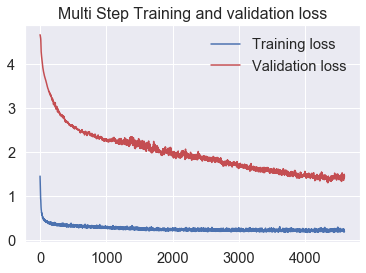

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #203
Restoring model weights from the end of the best epoch.
Epoch 01724: early stopping
Run #203 : val_loss = 1.9529057741165161

 Run #204
Restoring model weights from the end of the best epoch.
Epoch 01468: early stopping
Run #204 : val_loss = 2.0505452156066895

 Run #205
Restoring model weights from the end of the best epoch.
Epoch 01748: early stopping
Run #205 : val_loss = 1.9544371366500854

 Run #206
Restoring model weights from the end of the best epoch.
Epoch 01043: early stopping
Run #206 : val_loss = 2.0579335689544678

 Run #207
Restoring model weights from the end of the best epoch.
Epoch 02978: early stopping
Run #207 : val_loss = 1.6427663564682007

 Run #208
Restoring model weights from the end of the best epoch.
Epoch 01694: early stopping
Run #208 : val_loss = 2.052135705947876

 Run #209
Restoring model weights from the end of the best epoch.
Epoch 02377: early stopping
Run #209 : val_loss = 1.

Restoring model weights from the end of the best epoch.
Epoch 02919: early stopping
Run #263 : val_loss = 1.6820381879806519

 Run #264
Restoring model weights from the end of the best epoch.
Epoch 02264: early stopping
Run #264 : val_loss = 1.9330846071243286

 Run #265
Restoring model weights from the end of the best epoch.
Epoch 01690: early stopping
Run #265 : val_loss = 1.8305264711380005

 Run #266
Restoring model weights from the end of the best epoch.
Epoch 02047: early stopping
Run #266 : val_loss = 1.8170201778411865

 Run #267
Restoring model weights from the end of the best epoch.
Epoch 02337: early stopping
Run #267 : val_loss = 1.7915713787078857

 Run #268
Restoring model weights from the end of the best epoch.
Epoch 03552: early stopping
Run #268 : val_loss = 1.6665270328521729

 Run #269
Restoring model weights from the end of the best epoch.
Epoch 01932: early stopping
Run #269 : val_loss = 1.582579493522644

 Run #270
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 02737: early stopping
Run #324 : val_loss = 1.6885405778884888

 Run #325
Restoring model weights from the end of the best epoch.
Epoch 02172: early stopping
Run #325 : val_loss = 1.9366626739501953

 Run #326
Restoring model weights from the end of the best epoch.
Epoch 01694: early stopping
Run #326 : val_loss = 1.8011027574539185

 Run #327
Restoring model weights from the end of the best epoch.
Epoch 02069: early stopping
Run #327 : val_loss = 1.823466181755066

 Run #328
Restoring model weights from the end of the best epoch.
Epoch 02431: early stopping
Run #328 : val_loss = 1.7400518655776978

 Run #329
Restoring model weights from the end of the best epoch.
Epoch 01077: early stopping
Run #329 : val_loss = 2.1917476654052734

 Run #330
Restoring model weights from the end of the best epoch.
Epoch 01197: early stopping
Run #330 : val_loss = 2.0772721767425537

 Run #331
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 02683: early stopping
Run #385 : val_loss = 1.8147754669189453

 Run #386
Restoring model weights from the end of the best epoch.
Epoch 02512: early stopping
Run #386 : val_loss = 1.8112430572509766

 Run #387
Restoring model weights from the end of the best epoch.
Epoch 02500: early stopping
Run #387 : val_loss = 1.6692534685134888

 Run #388
Restoring model weights from the end of the best epoch.
Epoch 02719: early stopping
Run #388 : val_loss = 1.70913827419281

 Run #389
Restoring model weights from the end of the best epoch.
Epoch 01394: early stopping
Run #389 : val_loss = 1.9929828643798828

 Run #390
Restoring model weights from the end of the best epoch.
Epoch 01619: early stopping
Run #390 : val_loss = 2.096689462661743

 Run #391
Restoring model weights from the end of the best epoch.
Epoch 02544: early stopping
Run #391 : val_loss = 1.7798919677734375

 Run #392
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 03083: early stopping
Run #446 : val_loss = 1.881328821182251

 Run #447
Restoring model weights from the end of the best epoch.
Epoch 02103: early stopping
Run #447 : val_loss = 1.849959373474121

 Run #448
Restoring model weights from the end of the best epoch.
Epoch 02982: early stopping
Run #448 : val_loss = 1.7693973779678345

 Run #449
Restoring model weights from the end of the best epoch.
Epoch 02382: early stopping
Run #449 : val_loss = 1.865669846534729

 Run #450
Restoring model weights from the end of the best epoch.
Epoch 02476: early stopping
Run #450 : val_loss = 1.7960777282714844

 Run #451
Restoring model weights from the end of the best epoch.
Epoch 01509: early stopping
Run #451 : val_loss = 2.0831403732299805

 Run #452
Restoring model weights from the end of the best epoch.
Epoch 02940: early stopping
Run #452 : val_loss = 1.596219778060913

 Run #453
Restoring model weights from the end of the best epo

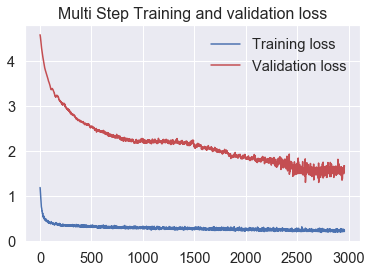

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #466
Restoring model weights from the end of the best epoch.
Epoch 02186: early stopping
Run #466 : val_loss = 2.1179938316345215

 Run #467
Restoring model weights from the end of the best epoch.
Epoch 01048: early stopping
Run #467 : val_loss = 2.1596038341522217

 Run #468
Restoring model weights from the end of the best epoch.
Epoch 01964: early stopping
Run #468 : val_loss = 1.8509548902511597

 Run #469
Restoring model weights from the end of the best epoch.
Epoch 00912: early stopping
Run #469 : val_loss = 2.2261245250701904

 Run #470
Restoring model weights from the end of the best epoch.
Epoch 01201: early stopping
Run #470 : val_loss = 2.2243292331695557

 Run #471
Restoring model weights from the end of the best epoch.
Epoch 01291: early stopping
Run #471 : val_loss = 2.0000393390655518

 Run #472
Restoring model weights from the end of the best epoch.
Epoch 03955: early stopping
Run #472 : val_loss = 1

Restoring model weights from the end of the best epoch.
Epoch 01872: early stopping
Run #526 : val_loss = 1.9328498840332031

 Run #527
Restoring model weights from the end of the best epoch.
Epoch 01120: early stopping
Run #527 : val_loss = 2.170492649078369

 Run #528
Restoring model weights from the end of the best epoch.
Epoch 01470: early stopping
Run #528 : val_loss = 2.1944832801818848

 Run #529
Restoring model weights from the end of the best epoch.
Epoch 01788: early stopping
Run #529 : val_loss = 2.113729953765869

 Run #530
Restoring model weights from the end of the best epoch.
Epoch 02643: early stopping
Run #530 : val_loss = 1.676889181137085

 Run #531
Restoring model weights from the end of the best epoch.
Epoch 01374: early stopping
Run #531 : val_loss = 1.8491878509521484

 Run #532
Restoring model weights from the end of the best epoch.
Epoch 02986: early stopping
Run #532 : val_loss = 1.5383284091949463

 Run #533
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 02351: early stopping
Run #587 : val_loss = 1.9716016054153442

 Run #588
Restoring model weights from the end of the best epoch.
Epoch 01408: early stopping
Run #588 : val_loss = 2.0073070526123047

 Run #589
Restoring model weights from the end of the best epoch.
Epoch 02883: early stopping
Run #589 : val_loss = 1.636495590209961

 Run #590
Restoring model weights from the end of the best epoch.
Epoch 01895: early stopping
Run #590 : val_loss = 1.8480074405670166

 Run #591
Restoring model weights from the end of the best epoch.
Epoch 01500: early stopping
Run #591 : val_loss = 1.978972315788269

 Run #592
Restoring model weights from the end of the best epoch.
Epoch 02131: early stopping
Run #592 : val_loss = 1.7115787267684937

 Run #593
Restoring model weights from the end of the best epoch.
Epoch 01625: early stopping
Run #593 : val_loss = 2.128357410430908

 Run #594
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 02383: early stopping
Run #648 : val_loss = 1.7237874269485474

 Run #649
Restoring model weights from the end of the best epoch.
Epoch 03329: early stopping
Run #649 : val_loss = 1.3509360551834106

 Run #650
Restoring model weights from the end of the best epoch.
Epoch 01801: early stopping
Run #650 : val_loss = 1.916464924812317

 Run #651
Restoring model weights from the end of the best epoch.
Epoch 04281: early stopping
Run #651 : val_loss = 1.692082166671753

 Run #652
Restoring model weights from the end of the best epoch.
Epoch 03048: early stopping
Run #652 : val_loss = 1.6769605875015259

 Run #653
Restoring model weights from the end of the best epoch.
Epoch 02074: early stopping
Run #653 : val_loss = 1.9032028913497925

 Run #654
Restoring model weights from the end of the best epoch.
Epoch 02227: early stopping
Run #654 : val_loss = 1.9625415802001953

 Run #655
Restoring model weights from the end of the best e

In [127]:
%%time
'''
Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
'''
NB_TRY = 700
EVALUATION_INTERVAL = 1
EPOCHS = 5000

# Hyper-parameters
# lr=6e-2 : err=1.23 mais diverge
# lr=1e-2 : err=1.22 mais pas eu le temps de converger (1 seul train)
# lr=0.5e-2 : err=1.29 mais pas eu le temps de converger (1 seul train)
# lr=2e-2 : err=1.18 Final val_loss = 1.181 people : 321 (juil 2020)
# lr=2e-2 : err= 1.83 Mean asbolute Error in people : 484 (aout 2020)
# lr=2e-2 : Final val_loss = 1.7202385663986206 / 453.984980383009 / 45min 10s / mid-august
# lr=2e-2 : Final val_loss = 5.082364559173584 Mean asbolute Error in people : 1540.5864920799772
# lr=2e-2 : Final val_loss = 4.183023452758789 Mean asbolute Error in people : 1630.9316293070544 Wall time: 2h 23min 11s
# lr=2e-2 : nb samples for training : 121 / nb samples for validation : 7
# Final val_loss = 0.861526608467102 Mean asbolute Error in people : 3446.437551562592 Wall time: 2h 39min 39s
# Final val_loss = 1.6073311567306519 Mean asbolute Error in people : 8765.89918940898 Wall time:3h28 patience=100
# Final val_loss = 1.2980750799179077 Mean asbolute Error in people : 7079.309850490991 Wall time: 6h 31min 34s patience=250
lr = 2e-2
decay = 1e-6 #1e-6
momentum = 0.9 # 0.9
nesterov = True # True
patience = 250 # 30

list_loss_multi = []

for I in range(NB_TRY):
    print("")
    print(f" Run #{I}")
    
    tf.keras.backend.clear_session()
    # optimizer def 
    sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                          nesterov=nesterov)

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=patience,
                                   restore_best_weights=True)
    # create model
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(features.shape[1], 
                                              return_sequences=False,
                                        input_shape=x_train_multi.shape[-2:]))
    multi_step_model.add(tf.keras.layers.Dropout(0.2))
    multi_step_model.add(tf.keras.layers.BatchNormalization())
    multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model.compile(optimizer=sgd_2, loss='mae')
    # fitting
    multi_step_history = multi_step_model.fit(train_data_multi, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_multi,
                                            validation_steps=1,
                                            callbacks=[es],
                                            verbose=0)
    # eval
    mae_curr = np.min(multi_step_history.history['val_loss'])
    
    if (I == 0):
        list_loss_multi.append(mae_curr)
        
    # find the best model
    print(f"Run #{I} : val_loss = {mae_curr}")
    if (mae_curr < np.min(list_loss_multi)) | (I == 0):
        # plot history
        plot_train_history(multi_step_history,
                   'Multi Step Training and validation loss')
        # save
        if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
            os.mkdir(PATH_MDL_MULTI_STEP)
        multi_step_model.save(PATH_MDL_MULTI_STEP)
        
    if (I != 0):   
        list_loss_multi.append(mae_curr)
    
print(" ")
print(f"Final val_loss = {np.min(list_loss_multi)}")
print("Mean asbolute Error in people :",
      data_std[4] * np.min(list_loss_multi))
print(" ")


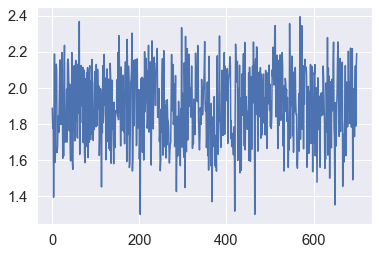

In [128]:
plt.plot(list_loss_multi)

### Eval

In [129]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

Wall time: 1.72 s


In [130]:
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)
print("Mean error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Mean nb cases  [nb of cases]: ", mean_val)
print("mean relative error [%]: ", 100*mean_error_val/mean_val)

Mean error  [nb of cases]:  7079.310077615612
Mean nb cases  [nb of cases]:  28799.448979591838
mean relative error [%]:  24.581408077051147


In [131]:
multi_step_model.predict(x_val_multi)

array([[2.001906 , 2.9136708, 3.4616072, 3.7334957, 4.769811 , 5.1911917,
        2.770012 ],
       [2.9763312, 3.8085833, 3.5214674, 3.8463435, 4.166815 , 2.6127295,
        0.932993 ],
       [3.4242644, 2.5320776, 4.2421327, 4.6515183, 2.6423116, 3.128193 ,
        6.8371835],
       [3.5472631, 3.9324822, 3.9647474, 2.580911 , 2.3862185, 5.332681 ,
        6.6011457],
       [3.7454877, 3.2784574, 2.7222116, 2.5914037, 3.7259305, 6.516281 ,
        6.9398794],
       [3.868233 , 2.1496284, 3.0784006, 4.823511 , 5.2940574, 6.5565515,
        7.9679446],
       [3.4426644, 1.808907 , 3.674488 , 5.5366893, 5.4277687, 6.495997 ,
        8.138345 ]], dtype=float32)

In [132]:
y_val_multi_pred.shape[0]

7

In [133]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 9), (None, 7)), types: (tf.float64, tf.float64)>

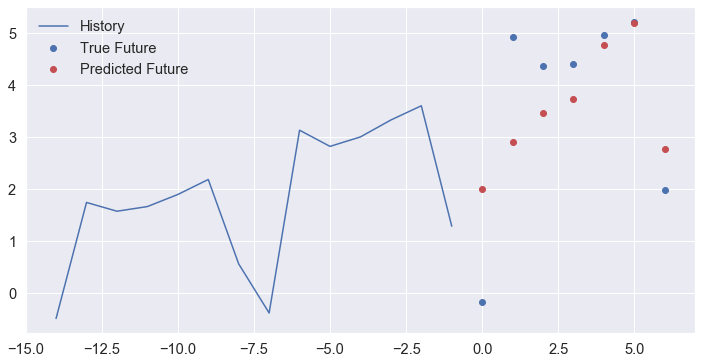

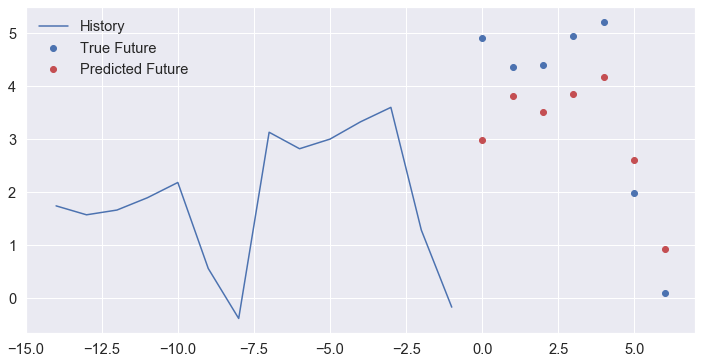

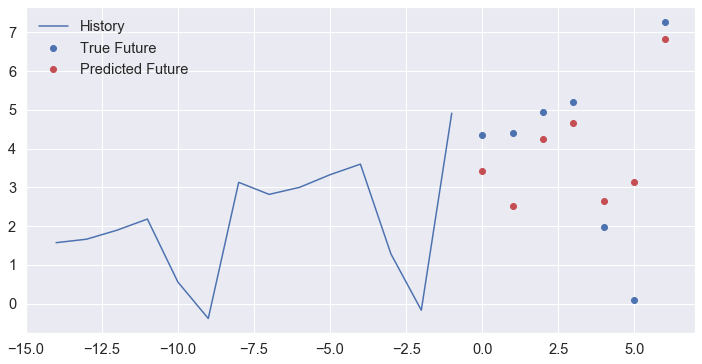

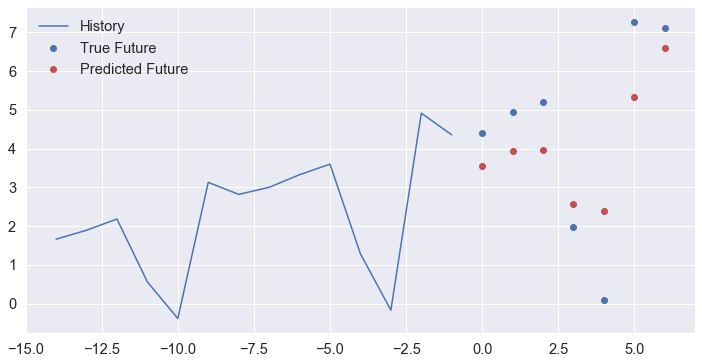

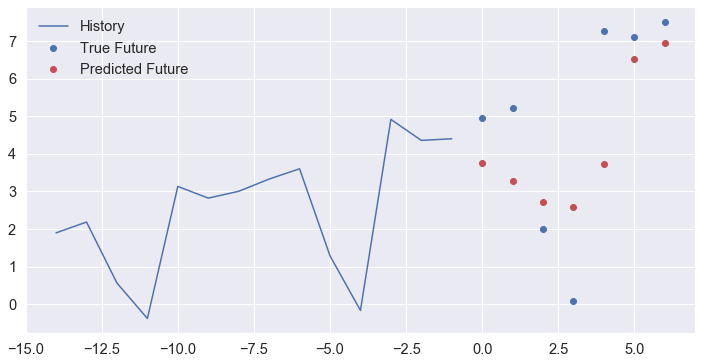

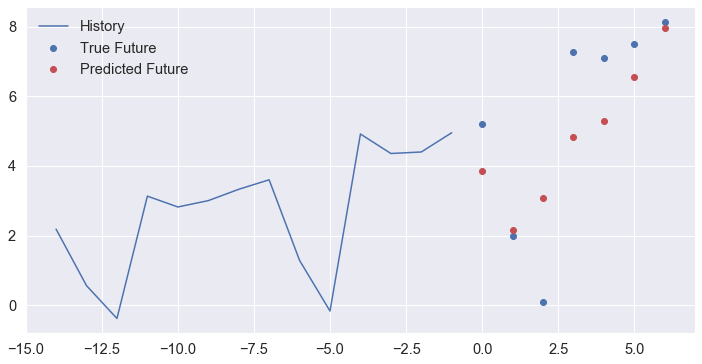

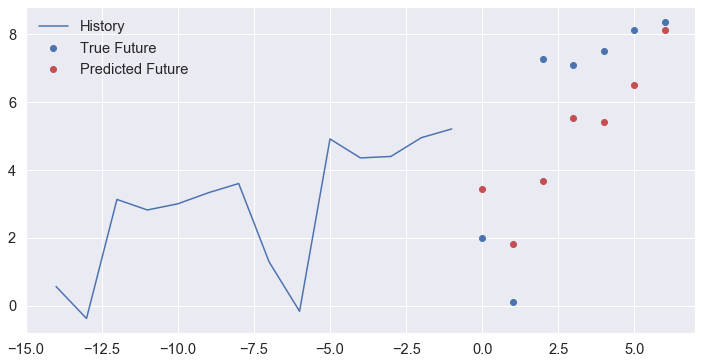

In [134]:
for x, y in val_data_multi.take(1):
    for I in range(y_val_multi_pred.shape[0]):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Prediction

In [135]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr'

In [136]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

In [137]:
TRAIN_SPLIT

151

In [138]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
# calculate mean & std 
#TRAIN_SPLIT = 93
# prepare dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [139]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


Wall time: 112 ms


In [140]:
dataset[-PAST_HISTORY:,4] * data_std[4] + data_mean[4]

array([ 3089., 30819., 27768., 28003., 31025., 32433., 14838.,  4501.,
       43656., 42752., 44953., 48369., 49650., 20791.])

In [141]:
y_pos_pred

array([[12660.262, 23635.65 , 34164.344, 24040.615, 23803.213, 36918.527,
        23766.318]], dtype=float32)

In [142]:
#dataset[-PAST_HISTORY-FUTURE_TARGET:,4] * data_std[4] + data_mean[4]

In [143]:
#y_pos_pred

In [144]:
df_feat_fr.date.max()

'2020-10-24'

In [145]:
df_feat_fr.pos.std()

9962.044491956416

In [146]:
data_std[4]

5453.69829527788

In [147]:
# last nth days

str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date    pos  nb_cases
2020-10-25  2020-10-25  12660   1180497
2020-10-26  2020-10-26  23635   1204132
2020-10-27  2020-10-27  34164   1238296
2020-10-28  2020-10-28  24040   1262336
2020-10-29  2020-10-29  23803   1286139
2020-10-30  2020-10-30  36918   1323057
2020-10-31  2020-10-31  23766   1346823

In [148]:
df_feat_fr.iloc[TRAIN_SPLIT]["date"]

'2020-10-11'

In [149]:
df_plot

T_min        date       T_max      H_min      H_max    pos  \
date                                                                          
2020-08-22  290.855000  2020-08-22  297.658333  53.310345  88.310345   2162   
2020-08-23  290.191667  2020-08-23  296.646667  52.758621  83.896552    946   
2020-08-24  288.921667  2020-08-24  296.960000  51.491525  84.559322   6860   
2020-08-25  288.920000  2020-08-25  298.748333  51.101695  85.220339   6674   
2020-08-26  290.243333  2020-08-26  297.823333  52.830508  84.000000   6523   
...                ...         ...         ...        ...        ...    ...   
2020-10-20  286.455000  2020-10-20  292.686667  65.169492  87.322034  42752   
2020-10-21  287.806897  2020-10-21  294.398276  59.245614  86.561404  44953   
2020-10-22  288.068333  2020-10-22  293.946667  66.254237  90.338983  48369   
2020-10-23  287.036441  2020-10-23  292.078814  70.017241  92.896552  49650   
2020-10-24  286.104237  2020-10-24  292.195763  66.327586  91.137931  20791   

              age_pos    test   age_test  day_num  nb_cases  
date                                                         
2020-08-22  39.667438   58783  46.292568        6    247212  
2020-08-23  40.139535   18907  45.902734        0    248158  
2020-08-24  39.994169  155226  46.308421        1    255018  
2020-08-25  39.614474  148653  46.273240        2    261692  
2020-08-26  39.609842  151139  46.125897        3    268215  
...               ...     ...        ...      ...       ...  
2020-10-20  47.891724  232637  46.025035        2   1004074  
2020-10-21  47.892221  236866  45.671688        3   1049027  
2020-10-22  47.876367  251342  46.241547        4   1097396  
2020-10-23  48.012145  266751  46.673043        5   1147046  
2020-10-24  47.526766  108847  46.477496        6   1167837  

[64 rows x 11 columns]

In [150]:
#df_plot.iloc[TRAIN_SPLIT]["date"]

### Figure

In [151]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_fr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", secondary_y=True)

fig.show()


### Predict all past

In [152]:
%%time
# prepare list of past histories
'''list_x = []
# prepare data : very last days
nb_max = math.ceil((NB_DAY_PLOT)/FUTURE_TARGET)
I_start_pred = TRAIN_SPLIT - nb_max*FUTURE_TARGET
for I in range(nb_max):
    I_start = I_start_pred + I * FUTURE_TARGET - PAST_HISTORY
    I_end =   I_start_pred + I * FUTURE_TARGET
    print(f"[{I_start} - {I_end}]")
    list_x.append(np.array([dataset[I_start:I_end, :]]))
print(len(list_x))'''

list_x = create_list_past_hist(dataset)
# predict
'''for I, x_multi in enumerate(list_x):
    if I:
        y_multi_pred = np.concatenate([y_multi_pred, 
            multi_step_model.predict(x_multi)], axis=1)
    else:
        y_multi_pred = multi_step_model.predict(x_multi)   '''
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[58 - 72]
[65 - 79]
[72 - 86]
[79 - 93]
[86 - 100]
[93 - 107]
[100 - 114]
[107 - 121]
[114 - 128]
9
Wall time: 234 ms


array([[  917.9812 ,   701.76953,   707.23584,   856.1267 ,  1077.8679 ,
         1319.4902 ,  1387.5974 ,  1025.6997 ,   804.1814 ,  1346.2786 ,
         1419.595  ,  1374.0442 ,  1721.4158 ,  1825.4629 ,  1572.6545 ,
         1396.5566 ,  1391.469  ,  1807.2888 ,  2281.6592 ,  2631.671  ,
         2600.9546 ,  2443.352  ,  2029.5382 ,  2334.9346 ,  3501.3657 ,
         4097.331  ,  4308.4614 ,  4464.3926 ,  3991.5842 ,  3176.0908 ,
         3163.585  ,  4921.753  ,  5970.107  ,  6144.8906 ,  6353.628  ,
         6079.561  ,  3557.973  ,  3278.9365 ,  6950.2173 ,  8987.695  ,
         8691.622  ,  9188.879  ,  8423.178  ,  4194.324  ,  3960.165  ,
        10126.38   , 12565.07   , 10731.44   , 12079.642  , 10242.689  ,
         3744.1194 ,  3950.464  , 12083.018  , 14859.043  , 11721.811  ,
        13495.363  ,  9813.963  ,  4479.9414 ,  3596.7986 , 11182.018  ,
        13681.504  , 10080.152  , 12139.841  ]], dtype=float32)

In [153]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_fr[df_feat_fr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

63
2020-08-22
2020-10-24


date    pos  nb_cases
2020-08-23  2020-08-23    917    248129
2020-08-24  2020-08-24    701    248830
2020-08-25  2020-08-25    707    249537
2020-08-26  2020-08-26    856    250393
2020-08-27  2020-08-27   1077    251470
...                ...    ...       ...
2020-10-20  2020-10-20   3596    931053
2020-10-21  2020-10-21  11182    942235
2020-10-22  2020-10-22  13681    955916
2020-10-23  2020-10-23  10080    965996
2020-10-24  2020-10-24  12139    978135

[63 rows x 3 columns]

In [154]:
add_days(str_date_pred_0, 0)

'2020-08-22'

In [155]:
str_date_pred_0

'2020-08-22'

In [156]:
df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values +1

array([ 9814, 14293, 17889, 29071, 42752, 52832, 64971], dtype=int32)

### Figure all past 

In [157]:
str_date_mdl =  df_feat_fr.iloc[TRAIN_SPLIT]["date"]

In [158]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)


fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()


In [159]:
df_plot_pred_all

date    pos  nb_cases
2020-08-23  2020-08-23    917    248129
2020-08-24  2020-08-24    701    248830
2020-08-25  2020-08-25    707    249537
2020-08-26  2020-08-26    856    250393
2020-08-27  2020-08-27   1077    251470
...                ...    ...       ...
2020-10-20  2020-10-20   3596    931053
2020-10-21  2020-10-21  11182    942235
2020-10-22  2020-10-22  13681    955916
2020-10-23  2020-10-23  10080    965996
2020-10-24  2020-10-24  12139    978135

[63 rows x 3 columns]

In [160]:
df_feat_fr[df_feat_fr["date"] == \
    df_plot_pred_all["date"].min()]["nb_cases"][0]

248158